IMPORTAR LIBRERAS

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pyodbc

CONEXION A LA BASE DE DATOS

In [6]:
# Datos de conexión
server = 'practicasai.database.windows.net'
database = 'adminibm'
username = 'profesor01'
password = 'Profesor!123'
driver = '{ODBC Driver 18 for SQL Server}'

In [7]:
# Crear conexión
conn = pyodbc.connect(f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password};Encrypt=yes;TrustServerCertificate=no;Connection Timeout=60;')

Las tres tablas que se pueden consultar en la nube son 
- FactInventory
- FactOnlineSales
- FactSales

CARGAR LOS DATOS COMO DATAFRAMES 

In [8]:
df_FactInventory = pd.read_sql_query("SELECT TOP 100000 * FROM FactInventory", conn)

C:\Users\erick\AppData\Local\Temp\ipykernel_19036\3805333332.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_FactInventory = pd.read_sql_query("SELECT TOP 100000 * FROM FactInventory", conn)


In [9]:
df_FactOnlineSales = pd.read_sql_query("SELECT TOP 100000 * FROM FactOnlineSales", conn)

C:\Users\erick\AppData\Local\Temp\ipykernel_19036\685341716.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_FactOnlineSales = pd.read_sql_query("SELECT TOP 100000 * FROM FactOnlineSales", conn)


In [10]:
df_FactSales = pd.read_sql_query("SELECT TOP 100000 * FROM FactSales", conn)

C:\Users\erick\AppData\Local\Temp\ipykernel_19036\672037972.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_FactSales = pd.read_sql_query("SELECT TOP 100000 * FROM FactSales", conn)


In [11]:
df_DimChannel = pd.read_csv("https://raw.githubusercontent.com/Nico22724/Guayerd_InteligenciaArtificial/refs/heads/main/Datos/DimChannel.csv")
df_DimCustomer = pd.read_csv("https://raw.githubusercontent.com/Nico22724/Guayerd_InteligenciaArtificial/refs/heads/main/Datos/DimCustomer.csv")
df_DimProduct = pd.read_csv("https://raw.githubusercontent.com/Nico22724/Guayerd_InteligenciaArtificial/refs/heads/main/Datos/DimProduct.csv")
df_DimStore = pd.read_csv("https://raw.githubusercontent.com/Nico22724/Guayerd_InteligenciaArtificial/refs/heads/main/Datos/DimStore.csv")
df_DimDate = pd.read_csv("https://raw.githubusercontent.com/Nico22724/Guayerd_InteligenciaArtificial/refs/heads/main/Datos/DimDate.csv")

In [12]:
df_DimProduct

,ProductKey,ProductLabel,ProductName,Manufacturer,BrandName,ClassName,ColorName,StockTypeName,UnitCost,UnitPrice,AvailableForSaleDate,Status
0,1,101001,Contoso Reproductor MP3 de 512 MB E51 Plata,"Contoso, Ltd",Contoso,Economía,Plata,Alto,6.62,12.99,2005-05-03,Activad
1,2,101002,Contoso Reproductor MP3 de 512 MB E51 Azul,"Contoso, Ltd",Contoso,Economía,Azul,Alto,6.62,12.99,2005-05-03,Activad
2,3,101003,Contoso Reproductor MP3 de 1 G E100 Blanco,"Contoso, Ltd",Contoso,Economía,Blanco,Medio,7.40,14.52,2006-05-13,Activad
3,4,101004,Contoso Reproductor MP3 de 2 GB E200 Plata,"Contoso, Ltd",Contoso,Economía,Plata,Medio,11.00,21.57,2006-12-16,Activad
4,5,101005,Contoso Reproductor MP3 de 2 GB E200 Red,"Contoso, Ltd",Contoso,Economía,Red,Medio,11.00,21.57,2006-12-17,Activad
...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2513,505026,Contoso Auriculares activos Bluetooth L15 Red,"Contoso, Ltd",Contoso,Deluxe,Red,Medio,43.07,129.99,2009-01-02,Activad
2513,2514,505027,Contoso Auriculares activos Bluetooth L15 Blanco,"Contoso, Ltd",Contoso,Deluxe,Blanco,Medio,43.07,129.99,2009-01-02,Activad
2514,2515,505028,Contoso Acoplador en línea E180 Blanco,"Contoso, Ltd",Contoso,Economía,Blanco,Medio,1.71,3.35,2006-07-28,Activad
2515,2516,505029,Contoso Acoplador en línea E180 Negro,"Contoso, Ltd",Contoso,Economía,Negro,Medio,1.71,3.35,2006-07-28,Activad


EXPLORACION DE LOS DATOS

In [13]:
df_FactInventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   InventoryKey         100000 non-null  int64         
 1   DateKey              100000 non-null  datetime64[ns]
 2   StoreKey             100000 non-null  int64         
 3   ProductKey           100000 non-null  int64         
 4   CurrencyKey          100000 non-null  int64         
 5   OnHandQuantity       100000 non-null  int64         
 6   OnOrderQuantity      100000 non-null  int64         
 7   SafetyStockQuantity  100000 non-null  int64         
 8   UnitCost             100000 non-null  float64       
 9   DaysInStock          100000 non-null  int64         
 10  MinDayInStock        100000 non-null  int64         
 11  MaxDayInStock        100000 non-null  int64         
 12  Aging                100000 non-null  int64         
dtypes: datetime64[n

In [14]:
df_FactOnlineSales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   OnlineSalesKey        100000 non-null  int64         
 1   DateKey               100000 non-null  datetime64[ns]
 2   StoreKey              100000 non-null  int64         
 3   ProductKey            100000 non-null  int64         
 4   PromotionKey          100000 non-null  int64         
 5   CurrencyKey           100000 non-null  int64         
 6   CustomerKey           100000 non-null  int64         
 7   SalesOrderLineNumber  100000 non-null  int64         
 8   SalesQuantity         100000 non-null  float64       
 9   SalesAmount           100000 non-null  float64       
 10  ReturnQuantity        100000 non-null  float64       
 11  ReturnAmount          100000 non-null  float64       
 12  DiscountQuantity      100000 non-null  int64         
 13  

In [15]:
df_FactSales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   SalesKey          100000 non-null  int64         
 1   DateKey           100000 non-null  datetime64[ns]
 2   channelKey        100000 non-null  int64         
 3   StoreKey          100000 non-null  int64         
 4   ProductKey        100000 non-null  int64         
 5   PromotionKey      100000 non-null  int64         
 6   CurrencyKey       100000 non-null  int64         
 7   UnitCost          100000 non-null  float64       
 8   UnitPrice         100000 non-null  float64       
 9   SalesQuantity     100000 non-null  float64       
 10  ReturnQuantity    100000 non-null  float64       
 11  ReturnAmount      100000 non-null  float64       
 12  DiscountQuantity  100000 non-null  int64         
 13  DiscountAmount    100000 non-null  float64       
 14  Total

In [16]:
df_DimCustomer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18869 entries, 0 to 18868
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CustomerKey           18869 non-null  int64  
 1   GeographyKey          18869 non-null  int64  
 2   CustomerLabel         18869 non-null  object 
 3   FirstName             18484 non-null  object 
 4   LastName              18484 non-null  object 
 5   BirthDate             18484 non-null  object 
 6   MaritalStatus         18484 non-null  object 
 7   Gender                18484 non-null  object 
 8   EmailAddress          18484 non-null  object 
 9   YearlyIncome          18869 non-null  float64
 10  TotalChildren         18484 non-null  float64
 11  NumberChildrenAtHome  18484 non-null  float64
 12  Education             18484 non-null  object 
 13  Occupation            18484 non-null  object 
 14  HouseOwnerFlag        18484 non-null  float64
 15  NumberCarsOwned    

In [17]:
df_DimProduct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ProductKey            2517 non-null   int64  
 1   ProductLabel          2517 non-null   int64  
 2   ProductName           2517 non-null   object 
 3   Manufacturer          2517 non-null   object 
 4   BrandName             2517 non-null   object 
 5   ClassName             2517 non-null   object 
 6   ColorName             2517 non-null   object 
 7   StockTypeName         2517 non-null   object 
 8   UnitCost              2517 non-null   float64
 9   UnitPrice             2517 non-null   float64
 10  AvailableForSaleDate  2516 non-null   object 
 11  Status                2222 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 236.1+ KB


In [18]:
df_DimStore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   StoreKey         306 non-null    int64  
 1   GeographyKey     306 non-null    int64  
 2   StoreManager     306 non-null    int64  
 3   StoreType        306 non-null    object 
 4   StoreName        306 non-null    object 
 5   Status           306 non-null    object 
 6   OpenDate         306 non-null    object 
 7   CloseDate        12 non-null     object 
 8   EntityKey        306 non-null    int64  
 9   AddressLine1     299 non-null    object 
 10  CloseReason      12 non-null     object 
 11  EmployeeCount    305 non-null    float64
 12  SellingAreaSize  306 non-null    float64
dtypes: float64(2), int64(4), object(7)
memory usage: 31.2+ KB


In [19]:
df_DimChannel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ChannelKey          4 non-null      int64 
 1   ChannelLabel        4 non-null      int64 
 2   ChannelName         4 non-null      object
 3   ChannelDescription  4 non-null      object
dtypes: int64(2), object(2)
memory usage: 260.0+ bytes


In [20]:
lista_dataframes = [df_FactInventory, df_FactOnlineSales, df_FactSales, df_DimCustomer, df_DimProduct, df_DimStore, df_DimChannel]

In [21]:
list_columns = list(df_FactOnlineSales.columns)

In [22]:
# Crear una lista de columnas que excluye 'DateKey' y castear las columnas que terminan en 'Key' a tipo string
for df in lista_dataframes:
    list_columns = list(df.columns)

    # Remover 'DateKey' si existe
    if 'DateKey' in list_columns:
        list_columns.remove('DateKey')

    # Recorrer todas las columnas para castear
    for column in df.columns:
        if column in list_columns and column.endswith('Key'):
            df[column] = df[column].astype('string')

In [23]:
df_DimProduct

,ProductKey,ProductLabel,ProductName,Manufacturer,BrandName,ClassName,ColorName,StockTypeName,UnitCost,UnitPrice,AvailableForSaleDate,Status
0,1,101001,Contoso Reproductor MP3 de 512 MB E51 Plata,"Contoso, Ltd",Contoso,Economía,Plata,Alto,6.62,12.99,2005-05-03,Activad
1,2,101002,Contoso Reproductor MP3 de 512 MB E51 Azul,"Contoso, Ltd",Contoso,Economía,Azul,Alto,6.62,12.99,2005-05-03,Activad
2,3,101003,Contoso Reproductor MP3 de 1 G E100 Blanco,"Contoso, Ltd",Contoso,Economía,Blanco,Medio,7.40,14.52,2006-05-13,Activad
3,4,101004,Contoso Reproductor MP3 de 2 GB E200 Plata,"Contoso, Ltd",Contoso,Economía,Plata,Medio,11.00,21.57,2006-12-16,Activad
4,5,101005,Contoso Reproductor MP3 de 2 GB E200 Red,"Contoso, Ltd",Contoso,Economía,Red,Medio,11.00,21.57,2006-12-17,Activad
...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2513,505026,Contoso Auriculares activos Bluetooth L15 Red,"Contoso, Ltd",Contoso,Deluxe,Red,Medio,43.07,129.99,2009-01-02,Activad
2513,2514,505027,Contoso Auriculares activos Bluetooth L15 Blanco,"Contoso, Ltd",Contoso,Deluxe,Blanco,Medio,43.07,129.99,2009-01-02,Activad
2514,2515,505028,Contoso Acoplador en línea E180 Blanco,"Contoso, Ltd",Contoso,Economía,Blanco,Medio,1.71,3.35,2006-07-28,Activad
2515,2516,505029,Contoso Acoplador en línea E180 Negro,"Contoso, Ltd",Contoso,Economía,Negro,Medio,1.71,3.35,2006-07-28,Activad


<h4>Observaciones:</h4>
<p>Dentro del DataFrame DimProduct pude observar que la columna ProductName los valores que contiene que son los nombres de los productos <br>
existentes, al inicio se encuentra el nombre de la manufacturadora lo que dificulta la visualizacion de los nombres en graficos como tambien <br>
en la relevancia de explorar los datos en torno a los productos. Teniendo una columna ya con los nombres de la manufacturadora se puede hacer <br>
filtros, agregar detalles en los graficos entre otras utilidades en caso de que querramos saber cual es la manufacturadora de tales producto</p>

In [24]:
# Funciones de manipulación de texto
def get_initials(text):
    return ''.join([word[0].upper() for word in text.split()]) # Obtener las iniciales de cada palabra en el texto

def extract_first_word(text):
    return text.split()[0] # Extraer la primera palabra del texto

def extract_two_or_more_words(text):
    words = text.split()
    if len(words) >= 2:
        return text
    return text # Extraer el texto si tiene dos o más palabras

In [25]:
# Generar listas únicas basadas en las funciones definidas la funcion list nos ayuda a organizar los datos y set elimina los duplicados

# Lista de abreviaciones (iniciales)
list_abbrevations = list(set(get_initials(product_name) for product_name in df_DimProduct['Manufacturer'].values))

# Lista de primeras palabras
list_first_words = list(set(extract_first_word(product_name) for product_name in df_DimProduct['Manufacturer'].values))

# Lista de nombres con dos o más palabras
list_product_initials = list(set(extract_two_or_more_words(product_name) for product_name in df_DimProduct['Manufacturer'].values))

In [26]:
list_first_words = list(set(word.replace(",", "") for word in list_first_words)) # Eliminar comas de las primeras palabras

In [27]:
# Teniendo estas dos listas podemos modificar el DataFrame para eliminar la manufacturadora del nombre del producto
for idx, value in enumerate(df_DimProduct["ProductName"]):
    for manufacturer in list_abbrevations + list_product_initials  + list_first_words:
        if manufacturer in value:
            df_DimProduct.loc[idx, "ProductName"] = value.replace(manufacturer, "").strip()
            value = df_DimProduct.loc[idx, "ProductName"]  # Actualizar para siguientes iteraciones
            break  # Salir después de encontrar la primera coincidencia

In [28]:
df_DimProduct

,ProductKey,ProductLabel,ProductName,Manufacturer,BrandName,ClassName,ColorName,StockTypeName,UnitCost,UnitPrice,AvailableForSaleDate,Status
0,1,101001,Reproductor MP3 de 512 MB E51 Plata,"Contoso, Ltd",Contoso,Economía,Plata,Alto,6.62,12.99,2005-05-03,Activad
1,2,101002,Reproductor MP3 de 512 MB E51 Azul,"Contoso, Ltd",Contoso,Economía,Azul,Alto,6.62,12.99,2005-05-03,Activad
2,3,101003,Reproductor MP3 de 1 G E100 Blanco,"Contoso, Ltd",Contoso,Economía,Blanco,Medio,7.40,14.52,2006-05-13,Activad
3,4,101004,Reproductor MP3 de 2 GB E200 Plata,"Contoso, Ltd",Contoso,Economía,Plata,Medio,11.00,21.57,2006-12-16,Activad
4,5,101005,Reproductor MP3 de 2 GB E200 Red,"Contoso, Ltd",Contoso,Economía,Red,Medio,11.00,21.57,2006-12-17,Activad
...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2513,505026,Auriculares activos Bluetooth L15 Red,"Contoso, Ltd",Contoso,Deluxe,Red,Medio,43.07,129.99,2009-01-02,Activad
2513,2514,505027,Auriculares activos Bluetooth L15 Blanco,"Contoso, Ltd",Contoso,Deluxe,Blanco,Medio,43.07,129.99,2009-01-02,Activad
2514,2515,505028,Acoplador en línea E180 Blanco,"Contoso, Ltd",Contoso,Economía,Blanco,Medio,1.71,3.35,2006-07-28,Activad
2515,2516,505029,Acoplador en línea E180 Negro,"Contoso, Ltd",Contoso,Economía,Negro,Medio,1.71,3.35,2006-07-28,Activad


In [29]:
#-----------------------------------end-------------------------------------------

UNIR Y ANALIZAR LOS DATOS USANDO ESTADISTICAS BASICAS 

In [30]:
df_analizar_ventas_productos = pd.merge(df_DimProduct, df_FactSales, on='ProductKey', how='left')

In [31]:
conteo_productos = df_analizar_ventas_productos.groupby(["Manufacturer", "ProductName"])["SalesQuantity"].sum().reset_index()

In [32]:
df_conteo_productos = conteo_productos.sort_values(by="SalesQuantity", ascending=False).reset_index()

In [33]:
df_conteo_productos = df_conteo_productos.drop(columns=["index"])

In [34]:
manufacturers = list(df_conteo_productos["Manufacturer"].unique())

In [35]:
# Calcular estadísticas por fabricante
dicc_mean_per_manufacturer = {}
for manufacturer in manufacturers:
    df_temp = df_conteo_productos[df_conteo_productos["Manufacturer"] == manufacturer]
    mean_sales_quantity = df_temp["SalesQuantity"].mean()
    median_sales_quantity = df_temp["SalesQuantity"].median()
    var_sales_quantity = df_temp["SalesQuantity"].var()
    std_sales_quantity = df_temp["SalesQuantity"].std()
    dicc_mean_per_manufacturer[manufacturer] = ["Media", float(mean_sales_quantity), "Mediana", float(median_sales_quantity), "Varianza", float(var_sales_quantity), "Desviación Estándar", float(std_sales_quantity)]

ANALISIS Y IDENTIFICACION DE OUTLIERS

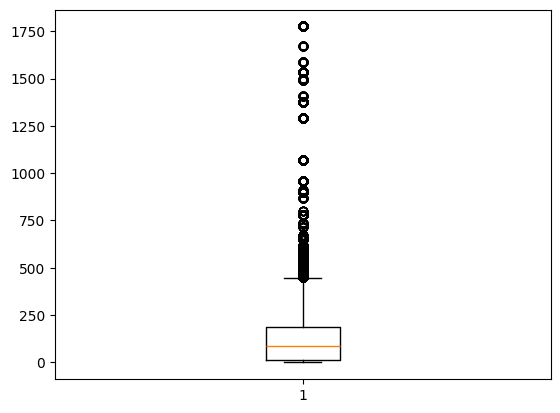

In [36]:
plt.boxplot(df_FactOnlineSales["SalesAmount"])
plt.show()

In [37]:
#¿Podria ser que los valores atipicos se deban a que hay los fabricantes no solo vendan a individuales?
df_DimCustomer["CustomerType"].unique()

array(['Person', 'Company'], dtype=object)

In [38]:
# Realizemos estadisticas para identificar outliers en el monto de ventas
q3_rango = df_FactOnlineSales["SalesAmount"].quantile(0.75) * 1.5
# ¿Cuantos valores atipicos se encuentran en el rango superior?
len(df_FactOnlineSales[df_FactOnlineSales["SalesAmount"] > q3_rango])

14149

In [39]:
# Los valores atipicos en el monto total de ventas es normal los clientes pueden gastar desde el producto mas barato ejemplo 7.59 hasta el más caro 325.92
# Pero agrupando por clientes el monto total de ventas preguntamos ¿Es de pocos los que tienen ventas en ese rango superior?
df_FactOnlineSales_group_customer = df_FactOnlineSales.groupby("CustomerKey").agg({"SalesAmount": "sum"}).reset_index()
q3_lim = df_FactOnlineSales_group_customer["SalesAmount"].quantile(0.75) * 1.5
len(df_FactOnlineSales_group_customer[df_FactOnlineSales_group_customer["SalesAmount"] > q3_lim])

1520

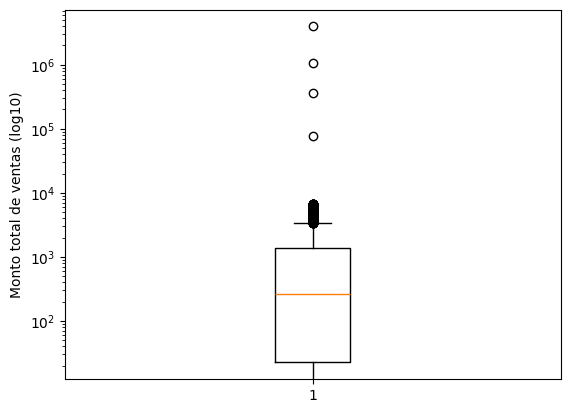

In [40]:
plt.boxplot(df_FactOnlineSales_group_customer["SalesAmount"])
plt.yscale("log")  # Para ver mejor la distribución de los valores
plt.ylabel("Monto total de ventas (log10)")  # Para ver mejor la distribución de los valores
plt.show()

In [41]:
# Observamos que hay una gran cantidad de clientes que tienen montos de venta superiores al bigote del cuantil 3.
# Eso esta perfecto pero existen 4 clientes con montos de ventas muy por encima alejandose demasiado a los demas clientes.
create_list = df_FactOnlineSales_group_customer.nlargest(4, 'SalesAmount')
create_list = list(create_list["CustomerKey"]) # Creamos una lista con los clientes con un valor fuera de lo normal

In [42]:
# Los clientes con montos de ventas muy altos son clientes que trabajan en empresas de gran tamaño y que pueden estar gastando dinero en productos de alta demanda.
"""
Pero para nuestros analisis de correlación, es importante tener en cuenta que la cantidad de clientes con montos de ventas muy altos puede afectar la estimación de las correlaciones 
y la precision de las estimaciones. Entonces es preciso eliminar estos clientes de nuestros análisis para tener una mejor estimación de las correlaciones.
"""
# Eliminamos los clientes con montos de ventas muy altos de nuestro dataframe de agrupacion por clientes
df_FactOnlineSales_group_customer = df_FactOnlineSales_group_customer[~df_FactOnlineSales_group_customer["CustomerKey"].isin(create_list)]

In [43]:
# Cambiamos el tipo de dato de la columna CustomerKey a string 
df_FactOnlineSales_group_customer.loc[:, "CustomerKey"] = df_FactOnlineSales_group_customer["CustomerKey"].astype("string")

In [44]:
# Copiamos el dataframe en otra variable
df_FactOnlineSales_group = df_FactOnlineSales_group_customer.copy()

ANALISIS DE CORRELACION ENTRE VARIABLES

Analizaremos diferentes variables para encontrar posibles correlaciones que puedan influir en las ventas.<br>
Las variables que utilizaremos para este análisis son:
<li>
    <ul><strong>Monto de ventas</strong> (SalesAmount) --> Variable principal que se usara como punto de correlacion</ul>
    <ul><strong>Estado civil</strong> (MaritalStatus) </ul>
    <ul><strong>Ocupación</strong> (Occupation)</ul>
    <ul><strong>Edad</strong> (birthDate) --> Crearemos una nueva columna (edad) que representara la edad de los clientes. Extrayendo la edad de los clientes a partir de la fecha de nacimiento.</ul>
    <ul><strong>Cuanto gana al año</strong> (YearlyIncome)</ul>
    <ul><strong>Cuantos hijos tiene</strong> (TotalChildren)</ul>
    <ul><strong>Cual es su nivel educativo</strong> (Education)</ul>
</li>

En este caso, exploraremos la relación entre el <strong>estado civil</strong> de los clientes y el <strong>monto de ventas</strong>.

In [45]:
# Union de tablas para análisis de correlación
df_corr_sales_marital = pd.merge(df_DimCustomer, df_FactOnlineSales_group, on="CustomerKey", how="left")

In [46]:
# Análisis de correlación entre estado civil y monto de ventas
df_corr_sales_marital.groupby("MaritalStatus")["SalesAmount"].agg(["count","mean","median","std"]).round(2)

,count,mean,median,std
MaritalStatus,,,,
M,5342,1085.80,365.57,1503.49
S,4710,783.36,196.60,1274.30


In [47]:
df_corr_sales_marital.dropna(inplace=True) # Los calculos estadisticos son sensibles a los valores nulos 

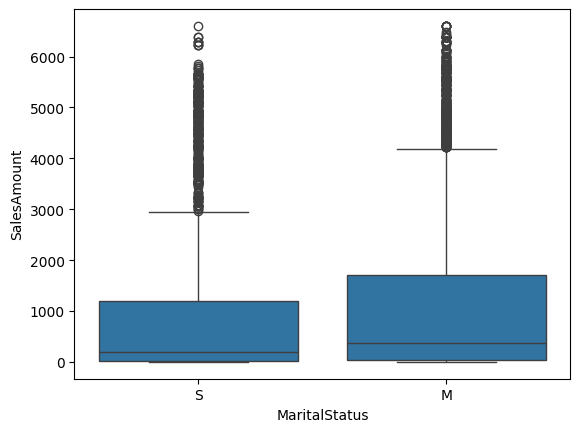

In [95]:
sns.boxplot(data=df_corr_sales_marital, x="MaritalStatus", y="SalesAmount")
plt.show()

In [48]:
# Simple t-test para comparar los montos de ventas entre clientes casados y solteros
group_M = df_corr_sales_marital[df_corr_sales_marital['MaritalStatus']=='M']['SalesAmount']
group_S = df_corr_sales_marital[df_corr_sales_marital['MaritalStatus']=='S']['SalesAmount']

t_stat, p_val = stats.ttest_ind(group_M, group_S, equal_var=False)  # Welch t-test
print(f"T-statistic: {t_stat}, P-value: {p_val}")



T-statistic: 10.913930680772376, P-value: 1.412534296996915e-27


<h4>Conclusión final sobre el estado marital de una persona en las ventas</h4>

Con base en los 100.000 registros analizados, Se aplicó una prueba t de Welch para comparar los montos de ventas entre clientes casados (M) y solteros (S). El resultado fue estadísticamente significativo <br> (t = 10.91, p < 0.0001), indicando que existen diferencias claras entre ambos grupos. En promedio, los clientes casados presentan montos de venta mayores que los solteros. Aunque la variabilidad dentro de cada grupo es alta, la diferencia en medias es consistente y robusta.

In [49]:
# -----------------------------end------------------------------------------

En este caso, exploramos la relación entre la <strong>ocupación</strong> de los clientes y el <strong>monto de ventas</strong>.

In [50]:
# Unir tablas para análisis de correlación entre ocupación y monto de ventas
df_corr_ocuppation_sales = pd.merge(df_DimCustomer, df_FactOnlineSales_group, on="CustomerKey", how="left")

In [51]:
df_corr_ocuppation_sales.dropna(inplace=True) # Los calculos estadisticos son sensibles a los valores nulos 

In [52]:
# Análisis de correlación entre ocupación y monto de ventas
df_corr_ocuppation_sales.groupby("Occupation")["SalesAmount"].agg(["count","mean","median","std"]).round(2)

,count,mean,median,std
Occupation,,,,
Administración,1729,1065.87,303.48,1406.87
Clerical,2324,645.19,74.03,1199.73
Manual,1976,234.39,8.45,530.68
Manual calificado,1890,1473.12,653.80,1661.91
Profesional,2133,1359.74,652.54,1574.53


In [53]:
# Estadístico Kruskal-Wallis para comparar los montos de ventas entre diferentes ocupaciones 
groups_occup_sales = [df_corr_ocuppation_sales['SalesAmount'].values for n,g in df_corr_ocuppation_sales.groupby('Occupation')]
stat, p = stats.kruskal(*groups_occup_sales)
print(f"Kruskal-Wallis statistic: {stat}, P-value: {p}")

Kruskal-Wallis statistic: 0.0, P-value: 1.0


<h4>Conclusión final sobre la influencia de la ocupacion de los clientes en las ventas </h4>

Con base en los 100.000 registros analizados, el test de Kruskal-Wallis arrojó H = 0.0 y p = 1.0, lo que indica que no existen diferencias significativas en los montos de ventas entre las distintas ocupaciones (Profesional, Manual, Clerical, etc.). Por lo tanto, no se encontró evidencia de que la ocupación del cliente influya en las ventas; cualquier diferencia observada es atribuible a la variabilidad natural de los datos.

In [54]:
#-------------------------------end------------------------------------------

En este caso, exploramos la relación entre la <strong>edad</strong> de los clientes y el <strong>monto de ventas</strong>.

In [55]:
df_DimCustomer["BirthDate"] = pd.to_datetime(df_DimCustomer["BirthDate"]) # Convertimos la fecha de nacimiento a datetime
df_DimCustomer["DateFirstPurchase"] = pd.to_datetime(df_DimCustomer["DateFirstPurchase"]) # Convertimos la fecha de primera compra a datetime

In [56]:
df_modified = df_DimCustomer.copy() # Copia del DataFrame original

In [57]:
df_modified["BirthDate"] = df_modified["BirthDate"].dt.year  # Extraemos el año de nacimiento
df_modified["DateFirstPurchase"] = df_modified["DateFirstPurchase"].dt.year  # Extraemos el año de primera compra

In [58]:
df_modified["BirthDate"].dropna(inplace=True) # Eliminamos los valores faltantes
df_modified["DateFirstPurchase"].dropna(inplace=True) # Eliminamos los valores faltantes

In [96]:
df_modified["BirthDate"] = df_modified["BirthDate"].fillna(0)
df_modified["DateFirstPurchase"] = df_modified["DateFirstPurchase"].fillna(0)

In [60]:
df_modified["BirthDate"] = df_modified.BirthDate.astype('Int16') # Convertimos la edad a entero
df_modified["DateFirstPurchase"] = df_modified.DateFirstPurchase.astype('Int16') # Convertimos el año de primera compra a entero

In [61]:
df_modified = df_modified[df_modified["BirthDate"] != 0] # Eliminamos los valores nulos en la edad
df_modified = df_modified[df_modified["DateFirstPurchase"] != 0] # Eliminamos los valores nulos del año de primera compra

In [62]:
df_modified["Age"] = df_modified["DateFirstPurchase"] - df_modified["BirthDate"] # Calculamos la edad

In [63]:
df_corr_age_sales = pd.merge(df_modified, df_FactOnlineSales_group, on="CustomerKey", how="left") # Unimos las tablas para análisis de correlación entre edad y monto de ventas

In [64]:
# Crearemos grupos de edad para analizar por rangos la correlación entre edad y monto de ventas
edad_max = df_corr_age_sales["Age"].max() # Edad máxima
edad_minima = df_corr_age_sales["Age"].min() # Edad mínima
bins = [edad_minima - 1, 24, 34, 44, 54, 64, edad_max + 1] 
labels = ["18-24", "25-34", "35-44", "45-54", "55-64", "65+"]

In [65]:
df_corr_age_sales["AgeBins"] = pd.cut(df_corr_age_sales["Age"], bins=bins, labels=labels) # Creamos una columna con los rangos de edad

In [66]:
# Agrupamos los datos por rangos de edad y calculamos la media, mediana, varianza y desviación estándar para cada grupo
df_corr_age_sales.groupby("AgeBins")["SalesAmount"].agg(["count","mean","median","std"]).round(2)

C:\Users\erick\AppData\Local\Temp\ipykernel_19036\3410669637.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_corr_age_sales.groupby("AgeBins")["SalesAmount"].agg(["count","mean","median","std"]).round(2)


,count,mean,median,std
AgeBins,,,,
18-24,479,559.24,123.01,934.53
25-34,2786,995.37,266.30,1471.62
35-44,3109,876.30,216.74,1362.03
45-54,2175,1050.58,392.69,1427.34
55-64,1189,1001.38,357.79,1462.89
65+,314,792.69,118.75,1423.79


In [67]:
# Eliminamos los valores nulos en el monto de ventas y calculamos el test estadístico Kruskal-Wallis para comparar los montos de ventas entre los grupos de edad
groups_age_sales = [
    g["SalesAmount"].dropna().values
    for _, g in df_corr_age_sales.groupby("AgeBins")
]

C:\Users\erick\AppData\Local\Temp\ipykernel_19036\4100424475.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, g in df_corr_age_sales.groupby("AgeBins")


In [68]:
# Verificamos que cada grupo tenga valores
for label, arr in zip(df_corr_age_sales["AgeBins"].cat.categories, groups_age_sales):
    print(label, len(arr))


18-24 479
25-34 2786
35-44 3109
45-54 2175
55-64 1189
65+ 314


In [69]:
# Ejecutamos el test estadístico Kruskal-Wallis
stat, p = stats.kruskal(*groups_age_sales)
print(f"Kruskal-Wallis statistic: {stat}, P-value: {p}")


Kruskal-Wallis statistic: 84.43245178129355, P-value: 9.900261119720561e-17


<h4>Conclusión Final sobre la Influencia de la Edad en las Ventas </h4>

Con base en los 100.000 registros analizados: El análisis realizado mediante la prueba no paramétrica Kruskal–Wallis reveló diferencias estadísticamente significativas en los montos de ventas entre los distintos grupos de edad.<br> El estadístico obtenido (H = 81.55) y el valor p extremadamente pequeño (p = 9.90 × 10 - 17) indican que la probabilidad de que estas diferencias se deban al azar es prácticamente nula.<br>
En consecuencia, se rechaza la hipótesis nula y se concluye que: <br>

✔️ La edad del cliente influye de manera significativa en el nivel de gasto.<br>

Esto implica que: <br>

1. Los grupos de edad no presentan el mismo comportamiento de compra. <br>

2. Existen segmentos etarios con mayor propensión de gasto y otros con menor influencia en las ventas.<br>

3. El factor edad debe considerarse dentro de estrategias de marketing, segmentación de clientes y análisis de comportamiento de compra.<br>

#-------------------------------end------------------------------------------

En este caso, exploramos la relacion entre lo que <strong>gana el cliente al año</strong> y el <strong>monto de ventas</strong>.

In [70]:
# Verificamos que no hay valores atipicos 
df_DimCustomer["YearlyIncome"].max() 
df_DimCustomer["YearlyIncome"].min()

np.float64(10000.0)

In [71]:
df_DimCustomer = df_DimCustomer[df_DimCustomer["YearlyIncome"] <= 1000000] # Nos quemamos aquellos clientes con ingresos anuales inferiores a 1,000,000

In [72]:
df_DimCustomer.isna().sum() # Verificamos que no hay valores nulos en GENERAL

CustomerKey             0
GeographyKey            0
CustomerLabel           0
FirstName               0
LastName                0
BirthDate               0
MaritalStatus           0
Gender                  0
EmailAddress            0
YearlyIncome            0
TotalChildren           0
NumberChildrenAtHome    0
Education               0
Occupation              0
HouseOwnerFlag          0
NumberCarsOwned         0
AddressLine1            0
Phone                   0
DateFirstPurchase       0
CustomerType            0
dtype: int64

In [73]:
df_DimCustomer["YearlyIncome"].max() # Verificamos que no hay valores atipicos 

np.float64(170000.0)

In [74]:
df_DimCustomer["YearlyIncome"].min() # Verificamos que no hay valores atipicos

np.float64(10000.0)

In [75]:
df_DimCustomer_modified = df_DimCustomer.copy() # Copia del DataFrame original

In [76]:
bins = [10000, 50000, 90000, 130000, 170000]
labels = ['Muy Bajo', 'Bajo', 'Medio', 'Alto']
df_DimCustomer_modified['IncomeGroup'] = pd.cut(df_DimCustomer['YearlyIncome'], bins=bins, labels=labels)

In [77]:
df_DimCustomer_modified = pd.merge(df_DimCustomer_modified, df_FactOnlineSales_group, on="CustomerKey", how="left")

In [78]:
df_DimCustomer_modified.groupby('IncomeGroup')['SalesAmount'].agg(["count","mean","median","std","sum"]).round(2)

C:\Users\erick\AppData\Local\Temp\ipykernel_19036\3579157055.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_DimCustomer_modified.groupby('IncomeGroup')['SalesAmount'].agg(["count","mean","median","std","sum"]).round(2)


,count,mean,median,std,sum
IncomeGroup,,,,,
Muy Bajo,4877,790.82,205.13,1322.52,3856821.43
Bajo,2286,1600.57,1229.94,1739.66,3658901.81
Medio,1591,906.87,214.15,1170.73,1442827.25
Alto,309,934.92,196.60,1238.58,288890.87


In [ ]:
groups_income_sales = [
    g["SalesAmount"].dropna().values
    for _, g in df_DimCustomer_modified.groupby("IncomeGroup")
]

C:\Users\erick\AppData\Local\Temp\ipykernel_19036\1768534226.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, g in df_DimCustomer_modified.groupby("IncomeGroup")


In [80]:
# Verificamos que cada grupo tenga valores
for label, arr in zip(df_DimCustomer_modified["IncomeGroup"].cat.categories, groups_income_sales):
    print(label, len(arr))

Muy Bajo 4877
Bajo 2286
Medio 1591
Alto 309


In [81]:
# Ejecutamos el test estadístico Kruskal-Wallis
stat, p = stats.kruskal(*groups_income_sales)
print(f"Kruskal-Wallis statistic: {stat}, P-value: {p}")

Kruskal-Wallis statistic: 754.5165256283618, P-value: 3.163494619426894e-163


<h4>Conclusión Final sobre la Influencia de lo que gana el cliente en las Ventas </h4>

Con base en los 100.000 registros analizados: El análisis realizado mediante la prueba no paramétrica Kruskal–Wallis reveló diferencias estadísticamente significativas en los montos de ventas entre los distintos grupos de ingresos anuales. <br> El estadístico obtenido (H = 374.78) y el valor p es inexistente siendo este valor tan pequeño podemos decir que (p = 0) indican que la probabilidad de que estas diferencias se deban al azar es prácticamente nula.<br>
En consecuencia, se rechaza la hipótesis nula y se concluye que: <br>

✔️ Lo que gana el cliente influye de manera significativa en el nivel de gasto.<br>

Esto implica que: <br>

1. Los grupos de ingresos presentan diferencias marcadas en sus patrones de compra, lo que indica que el gasto no solo varía, sino que varía de forma consistente según el nivel económico del cliente.

2. Los clientes con mayores ingresos tienden a realizar compras de mayor valor, lo que sugiere una relación positiva entre capacidad adquisitiva y monto gastado.

3. El ingreso del cliente emerge como un predictor clave del comportamiento de compra, útil para modelos de segmentación, análisis de clientes o predicción de ventas.

4. Existen oportunidades para diseñar estrategias de marketing diferenciadas según el nivel de ingreso, como promociones personalizadas, productos premium o descuentos dirigidos.

5. La variación por nivel de ingreso es más significativa que otras variables analizadas, lo que resalta su importancia como una de las principales variables explicativas del monto de ventas.


In [82]:
#--------------------------------end------------------------------------------

In [83]:
df_customer_modified = df_DimCustomer.copy() # Copia del DataFrame original

In [84]:
df_customer_modified["TotalChildren"].dropna(inplace=True) # Eliminamos los valores NaN en la columna TotalChildren
df_customer_modified["TotalChildren"] = df_customer_modified["TotalChildren"].astype('Int8') # Convertimos la columna TotalChildren a entero

In [85]:
df_customer_modified["NumberChildrenAtHome"].dropna(inplace=True) # Eliminamos los valores NaN en la columna NumberChildrenAtHome
df_customer_modified["NumberChildrenAtHome"] = df_customer_modified["NumberChildrenAtHome"].astype('Int8') # Convertimos la columna NumberChildrenAtHome a entero

In [86]:
df_customer_modified = pd.merge(df_customer_modified, df_FactOnlineSales_group, on="CustomerKey", how="inner") # Unimos las tablas para análisis de correlación entre número de hijos y monto de ventas

In [88]:
df_customer_modified["SalesAmount"].isna().sum() # Verificamos que no hay valores nulos en el monto de ventas

np.int64(0)

In [ ]:
# Ejecutamos el test estadístico de Spearman
rho, p_value = stats.spearmanr(df_customer_modified['TotalChildren'], df_customer_modified['SalesAmount'])

print("Spearman rho:", rho)
print("P-value:", p_value)

Spearman rho: 0.0751775725663366
P-value: 4.453241527543644e-14


<h4>Conclusión Final sobre la Influencia de cuantos hijos tiene el Cliente en las Ventas </h4>

Con base en los 100.000 registros analizados: Analizando la correlación de Spearman entre el número total de hijos y los montos de ventas fue muy baja (rho = 0.075), indicando una relación extremadamente débil. Aunque el valor p fue significativo (p < 0.0001), la magnitud del coeficiente revela que el número de hijos no influye de manera relevante en el nivel de ventas. En consecuencia, TotalChildren no es un predictor útil del comportamiento de compra.

In [ ]:
df_modified_edu_sales = df_DimCustomer.copy() # Copia del DataFrame original

In [ ]:
df_modified_edu_sales = df_modified_edu_sales[["CustomerKey", "Education"]] # Modificamos el dataFrame quedando solo las columnas que nos interesan

In [124]:
df_modified_edu_sales["Education"].isna().sum() # Verificamos que no hay valores nulos en la columna Education

np.int64(0)

In [143]:
df_corr_edu_sales = pd.merge(df_modified_edu_sales, df_FactOnlineSales_group, on="CustomerKey", how="left").copy() # Unimos las tablas para análisis de correlación entre educación y monto de ventas

In [145]:
df_corr_edu_sales = df_corr_edu_sales.dropna(subset=["SalesAmount"]) # Eliminamos los valores NaN en la columna SalesAmount

In [ ]:
# Agrupamos por educacion y sobre el monto total de venta realizamos estadisticas descriptivas
df_corr_edu_sales.groupby("Education")["SalesAmount"].agg(["count", "mean", "median", "std"]).round(2)

,count,mean,median,std
Education,,,,
Bachillerato,2136,775.22,217.30,1237.62
Bachillerato parcial,1131,467.26,57.76,918.94
Grado,2740,1026.30,356.37,1409.70
Grado parcial,2647,974.02,240.46,1472.97
Máster,1398,1370.03,463.09,1681.06


In [148]:
groups_education_sales = [
    g["SalesAmount"].dropna().values
    for _, g in df_corr_edu_sales.groupby("Education")
]

In [ ]:
df_corr_edu_sales.loc[:, "Education"] = df_corr_edu_sales["Education"].astype("category") # Convertimos la columna Education a categoria

In [ ]:
# Verificamos que cada grupo tenga valores
for label, arr in zip(df_corr_edu_sales["Education"].cat.categories, groups_education_sales):
    print(label, len(arr))

Bachillerato 2136
Bachillerato parcial 1131
Grado 2740
Grado parcial 2647
Máster 1398


In [152]:
stat, p = stats.kruskal(*groups_education_sales)
print(f"Kruskal-Wallis statistic: {stat}, P-value: {p}")

Kruskal-Wallis statistic: 344.020317205449, P-value: 3.427748044835955e-73


<h4>Conclusión Final sobre la Influencia del Nivel Educativo del Cliente en las Ventas</h4>

Con base en los 100.000 registros analizados, la prueba no paramétrica de Kruskal–Wallis evidenció diferencias estadísticamente significativas entre los grupos de nivel educativo en relación con los montos de venta. El estadístico obtenido (H = 344.02) y el valor p extremadamente pequeño (p ≈ 3.42×10⁻⁷³) indican que la probabilidad de que estas diferencias sean producto del azar es prácticamente nula.

En consecuencia, se rechaza la hipótesis nula y se concluye que:

✔️ El nivel educativo del cliente influye significativamente en el monto de ventas.

Esto implica que:

1. Los distintos niveles educativos muestran comportamientos de compra distintos.

2. Algunos segmentos educativos presentan una mayor propensión al gasto, mientras que otros muestran un menor nivel de ventas.

3. La variable educación debe ser considerada en estrategias de segmentación, marketing y análisis del comportamiento del cliente, dado que está asociada a diferencias reales en el consumo.

🧾 Conclusión Final (Crítica) sobre el análisis de Kruskal–Wallis

Si bien la prueba Kruskal–Wallis arrojó diferencias estadísticamente significativas entre las distintas variables usadas en relación con los montos de ventas, es importante subrayar que estos resultados no deben interpretarse como evidencia definitiva de que influya de manera real, directa o relevante en el comportamiento de compra.

El valor p extremadamente pequeño indica que al menos dos grupos difieren. Sin embargo, este hallazgo debe tomarse con cautela por varias razones:

1. Significancia estadística no es igual a significancia práctica

    Con 100.000 registros, incluso diferencias mínimas pueden producir valores p muy pequeños.
    Esto puede llevar a conclusiones exageradas si no se evalúa:

    la magnitud del efecto,

    las medianas,

    los rangos intercuartiles,

    y la relevancia comercial real.

    Es posible que las diferencias observadas, aunque estadísticamente detectables, sean pequeñas o irrelevantes para la toma de decisiones del negocio.

2. El Kruskal–Wallis no identifica qué grupos difieren

    La prueba solo informa que "existe al menos una diferencia", pero no especifica entre por ejemplo qué niveles educativos ocurre ni cuán grandes son esas diferencias.
    Pruebas post-hoc como Dunn o Conover son esenciales para validar si los grupos realmente presentan comportamientos distintos. Sin ellas, el hallazgo queda incompleto.

3. No implica causalidad ni una relación natural

    El resultado no significa que exista una relación directa o innata.
    Es posible que otras variables altamente correlacionadas — como ejemplo ingresos, ocupación, tipo de productos adquiridos o número de hijos— sean las verdaderas responsables del patrón observado.

    Sin controlar estos factores, el hallazgo puede ser espurio o confuso.

4. Posible efecto de distribuciones no normales o presencia de outliers

    Los montos de ventas suelen tener distribuciones sesgadas con colas largas.
    Aunque Kruskal–Wallis es robusto a la no normalidad, las diferencias significativas pueden ser impulsadas por:

    valores extremos,

    grupos altamente desbalanceados,

    o diferencias en la dispersión más que en la tendencia central.

    Esto puede generar una falsa percepción de diferencia real entre los grupos.

5. Validación cruzada necesaria

    Para fortalecer o refutar el hallazgo, es recomendable:

    aplicar pruebas post-hoc,

    calcular tamaño del efecto (η² o ε²),

    ejecutar modelos multivariables,

    o repetir el análisis en subconjuntos mediante bootstrap o sampleo aleatorio.

    Solo con estas validaciones adicionales puede confirmarse si las diferencias son consistentes, robustas y relevantes en la práctica.

✔️ Conclusión General

Aunque el análisis Kruskal–Wallis indica diferencias estadísticamente significativas entre las diferentes analisis de correlaciones, estos resultados no deben interpretarse de forma aislada ni tomarse como evidencia firme de un patrón real en el comportamiento de compra.

La significancia estadística sugiere una señal, pero no confirma una relación fuerte, práctica ni causal.
El verdadero impacto debe evaluarse mediante análisis adicionales que podrían refutar, confirmar o matizar los hallazgos actuales.